# Semantic Search in articles using NLP
### By/ Ahmed Essam

Semantic search is a search engine technology that interprets the meaning of words and phrases. The results of a semantic search will return content matching the meaning of a query, as opposed to content that literally matches words in the query.

Semantic search is a set of search engine capabilities, which includes understanding words from the searcher’s intent and their search context.

## Importing the needed Libraries

In [ ]:
import streamlit as st
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
stop_words = set(stopwords.words('english'))
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a.essam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.essam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a.essam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\a.essam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Loading and exploring the dataset

In [ ]:

dataset = load_dataset("csebuetnlp/xlsum", "english")

In [40]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 306522
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 11535
    })
    validation: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 11535
    })
})

In [41]:
# Step 1: Split the `train` set into `train` (e.g., 80%) and `validation` (e.g., 20%)
train_val_split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_data = train_val_split["train"]
val_data = train_val_split["test"]

# Step 2: Split `val_data` to get `validation` and `test` sets (50% each from remaining 20%)
val_test_split = val_data.train_test_split(test_size=0.5, seed=42)
validation_data = val_test_split["train"]
test_data = val_test_split["test"]

# Final DatasetDict
new_dataset = {
    "train": train_data,
    "validation": validation_data,
    "test": test_data
}

print(new_dataset)

{'train': Dataset({
    features: ['id', 'url', 'title', 'summary', 'text'],
    num_rows: 245217
}), 'validation': Dataset({
    features: ['id', 'url', 'title', 'summary', 'text'],
    num_rows: 30652
}), 'test': Dataset({
    features: ['id', 'url', 'title', 'summary', 'text'],
    num_rows: 30653
})}


In [42]:
train_data['text']

['The criticism was in a Care Quality Commission (CQC) letter to Hinchingbrooke Hospital ahead of a full report following a recent inspection. The Royal College of Nursing (RCN) said hospital staff felt bullied. The hospital said it was inappropriate to comment before the final report. The letter from CQC was leaked to the Health Service Journal last week. CQC visited Hinchingbrooke Hospital, which is run by the private company Circle, earlier this month. The letter highlighted the health watchdog\'s concerns, which will be published in full later this year. These included some patients who "lacked the capacity to consent" being sedated, and staff failing to update care plans or locking drugs away securely. \'Bullied and blamed\' Karen Webb, regional director of the RCN said: "I am horrified that patients are being put in a position where they don\'t feel they\'re getting dignified care, but equally horrified that staff are feeling they are not being treated as human beings either. "Ma

## Most Frequent words

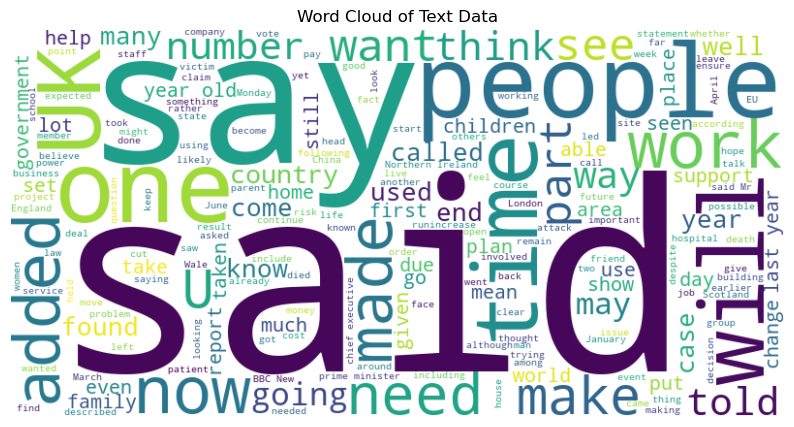

In [ ]:

# Step 2: Combine all text into a single string for the word cloud
combined_text = " ".join(train_data['text'])

# Step 3: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(combined_text)

# Step 4: Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Text Data')
plt.show()

C:\Users\a.essam\AppData\Local\Temp\ipykernel_19612\582036285.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')


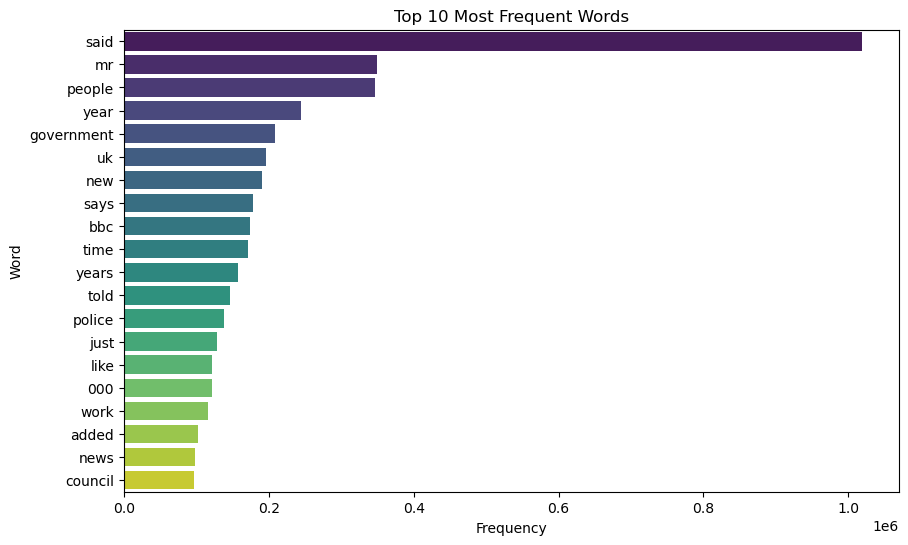

In [ ]:


# Step 1: Vectorize text to get word frequencies
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(train_data['text'])
sum_words = word_counts.sum(axis=0)

# Step 2: Get the most common words and their frequencies
word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
top_words = pd.DataFrame(word_freq[:20], columns=['Word', 'Frequency'])

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')
plt.title('Top 10 Most Frequent Words')
plt.show()

## Text preprocessing

In [ ]:


# Initialize NLTK tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Check if the input is a list and join it into a single string
    if isinstance(text, list):
        text = ' '.join(text)
    
    # Lowercase the text
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Join words back to form the cleaned text
    return ' '.join(words)


In [46]:

# Convert each dataset to a pandas DataFrame
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
validation_df = pd.DataFrame(validation_data)

# Apply pre-processing
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)
validation_df['cleaned_text'] = validation_df['text'].apply(preprocess_text)

In [48]:
train_df['cleaned_text']

0         criticism care quality commission cqc letter h...
1         leneto kellengbeck died multiple stab wound ar...
2         hacker using name tessa asking bitcoins anyone...
3         scottish government first revealed backing tun...
4         contractor say reading girl school poor condit...
                                ...                        
245212    draft plan say many test could needed vaughan ...
245213    swansea pembrey earmarked potential location a...
245214    trevor marshallseasydney capacity divide nonin...
245215    sanjoy majumderbbc news delhi old friend teach...
245216    antiterrorism officer surrounded house near re...
Name: cleaned_text, Length: 245217, dtype: object

In [ ]:

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

# Fit the vectorizer on the training set and transform all sets
tfidf_train = vectorizer.fit_transform(train_df['cleaned_text'])
tfidf_val = vectorizer.transform(validation_df['cleaned_text'])
tfidf_test = vectorizer.transform(test_df['cleaned_text'])


## TF-IDF DataFrame

In [72]:
tfidf_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_train, 
    columns=vectorizer.get_feature_names_out()
)

print(tfidf_df.head(10).to_markdown())

|    |   aa |   aaron |   abandon |   abandoned |   abandoning |   abbas |   abbey |   abbott |   abc |   abducted |   abduction |   abdul |   abdullah |   abe |   abedi |   aberdeen |   aberdeenshire |   aberystwyth |   abhorrent |   abide |   ability |      able |   abnormality |   aboard |   abolish |   abolished |   abolition |   aboriginal |   abortion |   abraham |   abroad |   absence |   absent |   absolute |   absolutely |   absorb |   absurd |   abu |     abuse |   abused |   abuser |   abusing |   abusive |   academic |   academy |   accelerate |   accelerated |   accelerating |   accent |   accept |   acceptable |   acceptance |   accepted |   accepting |   accepts |   access |   accessed |   accessible |   accessing |   accident |   accidental |   accidentally |   accolade |   accommodate |   accommodation |   accompanied |   accompanying |   accord |   accordance |   according |   accordingly |   account |   accountability |   accountable |   accountancy |   accountant | 

In [50]:
from sklearn.neighbors import NearestNeighbors

# Initialize KNN with k=5 (you can adjust k as needed) and cosine distance for similarity
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(tfidf_train)


NearestNeighbors(metric='cosine')

In [52]:
# Perform KNN search on validation set
val_distances, val_indices = knn.kneighbors(tfidf_val)

# Display some results
for i in range(5):  # Show results for the first 5 validation examples
    print(f"Validation Text {i}:\n", validation_df['cleaned_text'].iloc[i][:200], "...")
    print("\nTop Similar Articles from Train Set:")
    for idx, dist in zip(val_indices[i], val_distances[i]):
        print(f" - Train Article {idx} (Similarity: {1 - dist:.4f}):\n", train_df['cleaned_text'].iloc[idx][:200], "...\n")
    print("\n" + "-"*60 + "\n")


Validation Text 0:
 dale toten spent year tending big brassica seed nearly st kg ston easton park near bath planned exhibit mammoth vegetable weekend malvern autumn show although cabbage supposed offlimits unwitting chef ...

Top Similar Articles from Train Set:
 - Train Article 136103 (Similarity: 0.4213):
 david thomas leedstown presented kg lb vegetable year national giant vegetable championship mr thomas said proud beach ball sized cabbage previous record set mr r straw staveley derbyshire weighed kg  ...

 - Train Article 197597 (Similarity: 0.2980):
 emma wilkinsonhealth reporter bbc news analysis six study fruit vegetable intake food including spinach cabbage found significant positive effect portion half day found cut type diabetes risk british  ...

 - Train Article 213049 (Similarity: 0.2597):
 bake creme de la creme presented michelinstarred chef tom kerridge fifteen team professional chef compete produce impressive miniature showpiece dessert eightpart series shown bbc two 

In [53]:
# Perform KNN search on test set
test_distances, test_indices = knn.kneighbors(tfidf_test)

# Display some results
for i in range(5):  # Show results for the first 5 test examples
    print(f"Test Text {i}:\n", test_df['cleaned_text'].iloc[i][:200], "...")
    print("\nTop Similar Articles from Train Set:")
    for idx, dist in zip(test_indices[i], test_distances[i]):
        print(f" - Train Article {idx} (Similarity: {1 - dist:.4f}):\n", train_df['cleaned_text'].iloc[idx][:200], "...\n")
    print("\n" + "-"*60 + "\n")


Test Text 0:
 james gallagherhealth science reporter bbc news website nearly died condition kill people uk year bowel breast prostate cancer combined patrick nine month old one morning became poorly floppy generall ...

Top Similar Articles from Train Set:
 - Train Article 172124 (Similarity: 0.7434):
 sarah blochbudzierbbc news year ending april death hospital within day discharge sepsis leading cause prof sir brian jarman belief staff shortage overcrowding ward partly blame nh england said conditi ...

 - Train Article 222861 (Similarity: 0.7361):
 highlight sign symptom condition kill people scotland every year campaigner welcomed move describing game changer could ultimately save life publicity drive radio print social medium expected reach pe ...

 - Train Article 127681 (Similarity: 0.7159):
 come three week scottish government said think campaign necessary time announcement welcomed sepsis charity believe move save life sepsis kill people every year scotland caused immune system

In [ ]:
query = "climate change effects on agriculture"
query_vector = vectorizer.transform([query])
distances, indices = knn.kneighbors(query_vector)
# Step 5: Display the results (the closest training data examples)
for i, idx in enumerate(indices[0]):
    idx = int(idx)  # Convert numpy.int64 to regular Python int
    print(f"Rank {i+1} - Similarity: {1 - distances[0][i]:.4f}\n{train_data['text'][idx]}\n")

Rank 1 - Similarity: 0.5465
By Helen BriggsEnvironment correspondent, BBC News Concern has almost returned to the high levels reported in 2005, say University of Cardiff researchers. Britons named climate change as a major issue facing the UK alongside crime and education in a national survey. Many see climate change as contributing at least in part to floods, especially when they have been affected directly. However, while there is evidence that extreme weather events are becoming more common, scientists say it is not possible to attribute individual weather events to climate change. The storms that began in October 2013 forced many from their homes and made the 2013-14 winter the wettest on record. More than 5,000 homes and businesses were flooded and many rivers in southern England reached their highest ever recorded levels. A year on, researchers surveyed 1,000 people across the UK about their attitudes to climate change and the floods. A follow-up study of 995 people was conducted

## Using transformers embeddings

In [ ]:


# Initialize the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Example data: Replace with your dataset's `cleaned_text` column
texts = train_df['text'].tolist()

# Generate embeddings for each text in the dataset
embeddings = model.encode(texts, convert_to_tensor=False)
embeddings = np.array(embeddings).astype("float32")  # FAISS requires float32

# Normalize embeddings to use cosine similarity
faiss.normalize_L2(embeddings)

# Create a FAISS index (using IndexFlatIP for inner product, which is equivalent to cosine similarity on normalized vectors)
index = faiss.IndexFlatIP(embeddings.shape[1])  # IP = Inner Product (dot product)
index.add(embeddings)

In [73]:
embeddings

array([[-0.04332602,  0.0343613 , -0.02388822, ..., -0.03150532,
         0.13611417,  0.0351498 ],
       [-0.04636629, -0.05068205, -0.04126064, ..., -0.04043744,
         0.0714128 , -0.05814699],
       [-0.13713582,  0.01882575, -0.00259452, ..., -0.10851925,
         0.03551875, -0.01086651],
       ...,
       [ 0.00584275,  0.05973119, -0.02437935, ...,  0.014366  ,
        -0.03331335,  0.02198501],
       [-0.05738626, -0.04991867,  0.07033201, ..., -0.02956579,
        -0.10470925, -0.03407184],
       [ 0.04000724,  0.11531185, -0.03935179, ..., -0.10339983,
        -0.12883648,  0.01681273]], dtype=float32)

In [62]:
# Function to query similar items
def query_similar(text, top_k=5):
    # Encode the query text
    query_embedding = model.encode([text], convert_to_tensor=False)
    query_embedding = np.array(query_embedding).astype("float32")
    
    # Normalize the query embedding for cosine similarity
    faiss.normalize_L2(query_embedding)

    # Perform the search in the FAISS index
    distances, indices = index.search(query_embedding, top_k)

    # Retrieve and display the results
    results = []
    for i, idx in enumerate(indices[0]):
        results.append((texts[idx], distances[0][i]))  # Pair text with similarity score

    return results

In [63]:
# Example usage
query_text = "climate change effects on agriculture"
results = query_similar(query_text, top_k=5)

# Display results
for i, (text, score) in enumerate(results):
    print(f"Result {i+1} - Similarity: {score:.4f}\n{text}\n")

Result 1 - Similarity: 0.6070
By Vaishnavi SeetharamanBBC Tamil It has projected a temperature rise of between 1.7C and 2C in India over the next 20 years. The study says India faces increased precipitation and storms and a continuing sea level rise. It also warned of food shortages because of a decline in farm output. "Climate change scenarios for 2030 indicate an overall warming over the Indian sub-continent associated with increasing greenhouse gas concentrations," said the report by the Indian Network for Climate Change Assessment (INCCA). There is expected to be a "significant dip" in the production of rice, maize and sorghum, the report said. Production of apples in the Himalayan region could also be affected. "No country in the world is as vulnerable, on so many dimensions, to climate change as India," said federal environmental minister Jairam Ramesh, while releasing the report.

Result 2 - Similarity: 0.5991
By Nassos Stylianou, Clara Guibourg and Helen BriggsBBC News Switchin